In [1]:
from __future__ import division, print_function
import sympy
import sympy.physics.mechanics as mech
import pylab as pl
import scipy.integrate
import quaternion

import sympy_utils

%matplotlib inline
pl.rcParams['lines.linewidth'] = 3
pl.rcParams['figure.figsize'] = (15,5)

## Simulation

In [2]:
def sim_func(u_func, lam, x0, a_b_func, dt=0.01, tf=10):
    """
    u_func: input [omega_x, omega_y, omega_z, b_x_dot, b_y_dot, b_z_dot]
    a_b_func: random body accels f(t, x)
    """
    sim = scipy.integrate.ode(lam['f_sim'])
    sim.set_initial_value(x0)
    data = {'x': [], 'u': [], 't': [],
           'y_accel': [], 'y_mag': [],
           'y_gyro': [], 'a_b': []}
    g = 9.8
    mag_noise = 1e-1
    accel_noise = 1e-2
    gyro_nosie = 1e-3
    a_b_noise = 1e-3
    m_n = pl.array([1,0,1])
    m_n = m_n / pl.norm(m_n)
    while sim.t < tf:
        t = sim.t
        x = sim.y
        u = u_func(t, x)
        a_b = a_b_func(t, x) # random body accelerations
        sim.set_f_params(u)
        sim.integrate(t + dt)
        data['x'] += [x]
        data['u'] += [u]
        data['t'] += [t]
        data['y_accel'] += [lam['f_y_accel'](x, g, a_b)[:,0] + accel_noise*pl.randn(3)]
        data['y_mag'] += [lam['f_y_mag'](x, m_n)[:,0] + mag_noise*pl.randn(3)]
        data['y_gyro'] += [u[:3] + gyro_nosie*pl.randn(3) + x[7:]]
        data['a_b'] += [a_b + a_b_noise*pl.randn(3)]
        
    data = {key: pl.array(data[key]) for key in data.keys()}
    return data

In [3]:
def sim_est(data, lam, dt):
    data_est = {'x': [], 'P':[], 't':[]}
    q = pl.array([1,0,0,0])
    P = 1e-4*pl.eye(6)
    Q = 1e-4*pl.eye(6)
    g = 9.8
    m_n = pl.array([1,0,1])
    m_n = m_n/pl.norm(m_n)
    R_mag = 1e-4*pl.eye(3)
    R_accel = 1e-2*pl.eye(3)
    b = pl.array([0,0,0])
    
    for i in range(len(data['t'])):
        
        omega = data['y_gyro'][i]
        A = lam['f_A'](q, omega)
        P = P + (A.dot(P) + P.dot(A.T) + Q)*dt;
        q = q + lam['f_sim_est'](q, omega - b)[:,0]*dt
        
        if (i%10 == 0):
        
            # accel 
            a_b = pl.array(data['a_b'][i]) # assume we get this from pos ekf
            y_accel = pl.array(data['y_accel'][i])
            C_accel = lam['f_C_accel'](q, g) 
            S_accel = C_accel.dot(P).dot(C_accel.T) + R_accel
            K_accel = P.dot(C_accel.T).dot(pl.linalg.inv(S_accel))
            r_accel = y_accel - lam['f_y_accel'](q, g, a_b)[:,0]
            dx_accel = K_accel.dot(r_accel)
            dq_alpha = lam['f_quat_from_euler'](*dx_accel[:3])
            P = (pl.eye(6) - K_accel.dot(C_accel)).dot(P)
            q = quaternion.quat_prod(q, dq_alpha)
            b = b - dx_accel[3:6]
            
            # mag
            y_mag = data['y_mag'][i]
            y_mag = y_mag/pl.norm(y_mag)
            C_mag = lam['f_C_mag'](q, g, m_n)
            S_mag = C_mag.dot(P).dot(C_mag.T) + R_mag
            K_mag = P.dot(C_mag.T).dot(pl.linalg.inv(S_mag))
            r_mag = y_mag - lam['f_y_mag'](q, m_n)[:,0]
            dx_mag = K_mag.dot(r_mag)
            dq_mag = lam['f_quat_from_euler'](*dx_mag[:3])
            P = (pl.eye(6) - K_mag.dot(C_mag)).dot(P)
            q = quaternion.quat_prod(q, dq_mag)
            b = b - dx_mag[3:6]
            
            # normalize quternion
            q = q/pl.norm(q)
        
        data_est['t'] += [data['t'][i]]
        data_est['x'] += [list(q) + list(b)]
        data_est['P'] += [P]
        
    data_est = {key: pl.array(data_est[key]) for key in data_est.keys()}
    return data_est

In [8]:
dt = 0.001
x0 = pl.zeros(10)
x0[0] = 1
lambda_funcs = sympy_utils.load('deriv.pkl')['lambda_functions']
def u_function(t, x):
    return pl.array([1,2,3,0.1,0.2,0.3]) + 0*pl.randn(6)
def a_b_func(t, x):
    # simulate a 1-g turn from 5 to 10 seconds
    if (t > 5 and t < 10):
        return [0,9.8,0]
    else:
        return [0,0,0]
data = sim_func(u_func=u_function, a_b_func=a_b_func, lam=lambda_funcs, x0=x0, dt=dt, tf=100)
data_est = sim_est(data, lambda_funcs, dt)

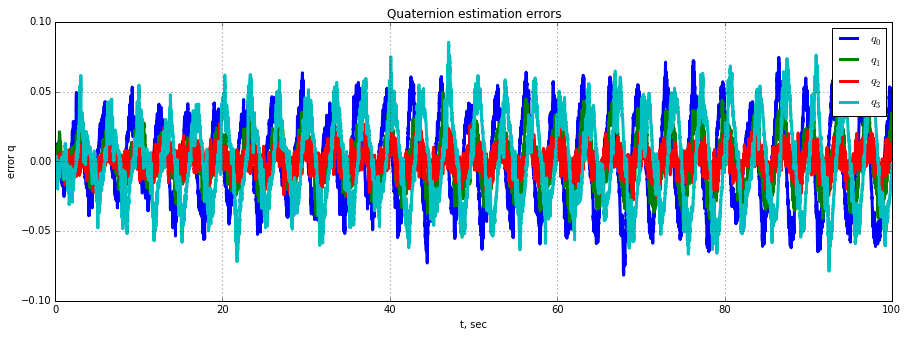

In [9]:
pl.figure()
pl.plot(data_est['t'], data_est['x'][:,0] - data['x'][:,0], label='$q_0$');
pl.plot(data_est['t'], data_est['x'][:,1] - data['x'][:,1], label='$q_1$');
pl.plot(data_est['t'], data_est['x'][:,2] - data['x'][:,2], label='$q_2$');
pl.plot(data_est['t'], data_est['x'][:,3] - data['x'][:,3], label='$q_3$');
pl.grid()
pl.ylabel('error q')
pl.xlabel('t, sec')
pl.title('Quaternion estimation errors')
pl.legend()

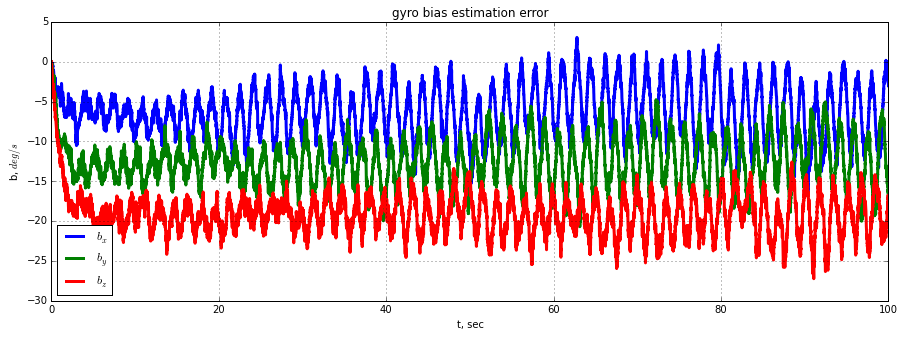

In [10]:
pl.plot(data_est['t'], pl.rad2deg(data_est['x'][:,4]) - pl.rad2deg(data['x'][:,7]), label='$b_x$');
pl.plot(data_est['t'], pl.rad2deg(data_est['x'][:,5]) - pl.rad2deg(data['x'][:,8]), label='$b_y$');
pl.plot(data_est['t'], pl.rad2deg(data_est['x'][:,6]) - pl.rad2deg(data['x'][:,9]), label='$b_z$');
pl.xlabel('t, sec')
pl.ylabel('b, $deg/s$')
pl.title('gyro bias estimation error')
pl.legend(loc='best')
pl.grid()

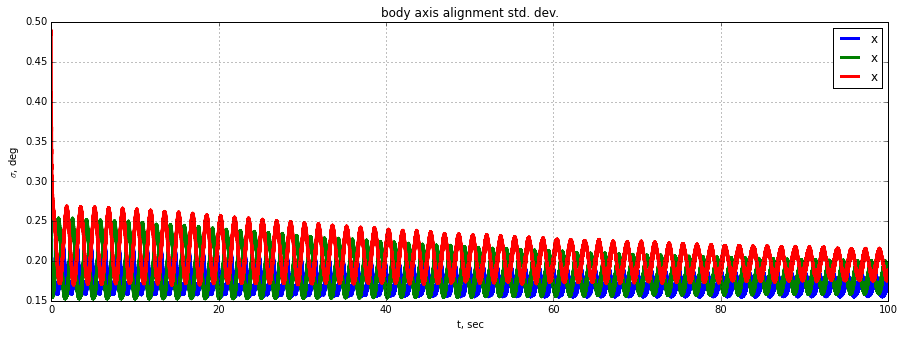

In [11]:
pl.figure()
pl.plot(data_est['t'],
        pl.rad2deg(pl.sqrt(data_est['P'][:,0,0])), label='x');
pl.plot(data_est['t'],
        pl.rad2deg(pl.sqrt(data_est['P'][:,1,1])), label='x');
pl.plot(data_est['t'],
        pl.rad2deg(pl.sqrt(data_est['P'][:,2,2])), label='x');
pl.title('Quaternion estimation errors')
pl.ylabel('$\sigma$, deg')
pl.xlabel('t, sec')
pl.title('body axis alignment std. dev.')
pl.legend()
pl.grid()